<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [188]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [189]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z / torch.exp(self.s)
        log_det_j = torch.sum(torch.abs(self.s))

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [190]:
a = np.array([[1,2,3,4,5,6,7,8],
             [9,10,11,12,13,14,15,16]])

In [191]:
a[:, 1::2]

array([[ 2,  4,  6,  8],
       [10, 12, 14, 16]])

In [192]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

train_data = Data(X_train)


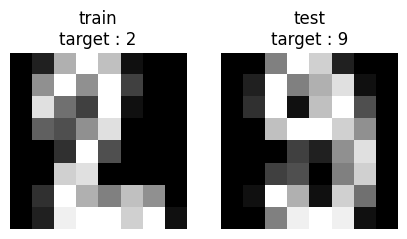

In [193]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [194]:
data_dim = 8*8
"""
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))

model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)


In [195]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  78.07422256469727
Epoch :  2   -----------> Loss :  36.399802344185964
Epoch :  3   -----------> Loss :  31.044864790780203
Epoch :  4   -----------> Loss :  26.017421313694545
Epoch :  5   -----------> Loss :  20.975526128496444
Epoch :  6   -----------> Loss :  16.575784342629568
Epoch :  7   -----------> Loss :  12.918220928737096
Epoch :  8   -----------> Loss :  10.78182131903512
Epoch :  9   -----------> Loss :  8.657676833016533
Epoch :  10   -----------> Loss :  7.321035010474069
Epoch :  11   -----------> Loss :  6.906572648457119
Epoch :  12   -----------> Loss :  6.452607120786395
Epoch :  13   -----------> Loss :  6.153293779918125
Epoch :  14   -----------> Loss :  6.531261410032
Epoch :  15   -----------> Loss :  6.828174999782017
Epoch :  16   -----------> Loss :  6.019459043230329
Epoch :  17   -----------> Loss :  5.684771231242588
Epoch :  18   -----------> Loss :  5.489704540797642
Epoch :  19   -----------> Loss :  5.414211784090314

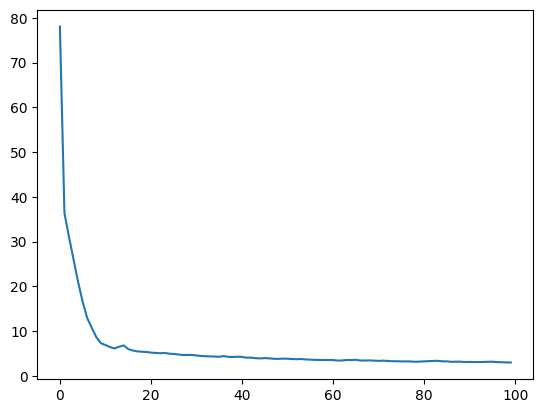

In [196]:
plt.plot(COST)

In [197]:
test = prior.sample((50,))
test

tensor([[-0.5244,  0.1654, -0.4501,  ..., -2.0307,  0.6297,  0.5593],
        [ 1.1091,  1.7838, -1.6736,  ...,  0.2654, -0.3514,  0.5063],
        [ 1.0620,  0.5344, -1.4378,  ..., -0.6642,  0.1152,  0.9297],
        ...,
        [-0.7401,  0.9919, -1.6170,  ..., -0.3469,  0.4643, -1.1494],
        [ 0.3669,  0.1086, -0.6629,  ...,  1.6684,  1.7423,  0.2891],
        [-0.6326, -0.5472, -0.1626,  ...,  0.3414, -0.6674,  0.9241]])

In [198]:
sonuc = model.f_inv(test)
sonuc

tensor([[-0.5136,  0.2603,  7.0258,  ...,  0.5755,  0.0758,  0.1264],
        [ 0.2265,  3.4934, 18.0323,  ...,  0.3692,  1.6662,  0.6735],
        [ 0.9577,  1.8616, 14.2916,  ..., -4.4362, -0.1724,  0.5665],
        ...,
        [ 0.0939,  0.5638,  0.5956,  ..., 10.7486,  2.1054, -0.0598],
        [ 0.6617,  0.6823,  2.9691,  ..., 12.7934,  1.9681, -0.0940],
        [-1.1140, -0.5537, -0.8771,  ...,  3.0801, -0.7062,  0.1077]],
       grad_fn=<CopySlices>)

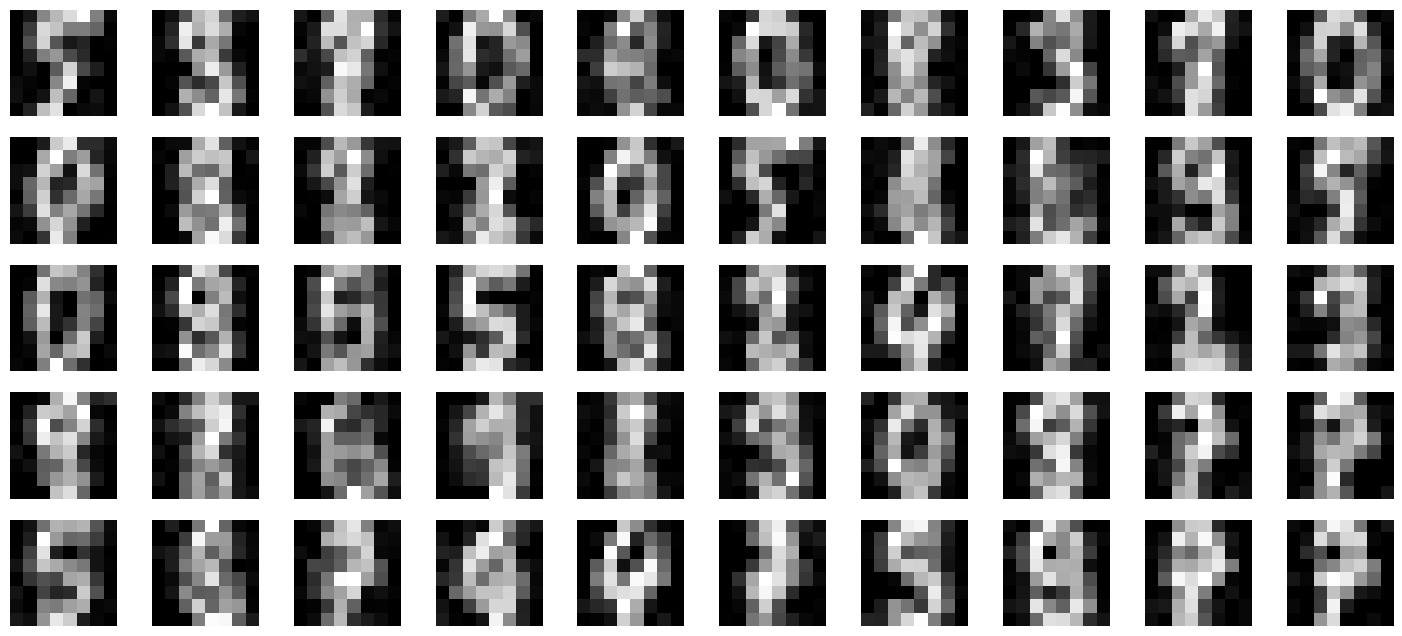

In [199]:
test = prior.sample((50,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()